# Lorenz

Lo primero es generar los datos con los que alimentaré el modelo:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import pysindy as ps
import math

Variables globales:

In [2]:
paso_tiempo=0.001

Este código es el que me dio Pablo de la página web de matplotlib

In [3]:

def lorenz(x, a=10.0, b=28.0, c=8/3):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = a*(x[1] - x[0])
    y_dot = b*x[0] - x[1] - x[0]*x[2]
    z_dot = x[0]*x[1] - c*x[2]
    
    return x_dot, y_dot, z_dot

def solverLorenz(x0, dt=0.01, num_steps=10000):

    # Need one more for the initial values
    xs = np.empty(num_steps + 1)
    ys = np.empty(num_steps + 1)
    zs = np.empty(num_steps + 1)

    # Set initial values
    xs[0], ys[0], zs[0] = x0

    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps):
        arr = [xs[i], ys[i], zs[i]]
        x_dot, y_dot, z_dot = lorenz(arr)
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
        
    return xs, ys, zs

Pequeña prueba para ver qué tal plotea el solver

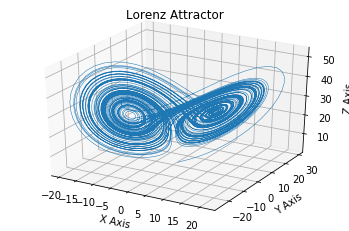

In [4]:

# Set initial values
x0 = [1., 1., 1.]
xs, ys, zs = solverLorenz(x0)

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

Lorenz escrito por mi: Odeint obliga a escribir de una forma determinada los argumentos de la EDO a calcular, así que mejor reescribirlo

In [5]:
def lorenz2(state, t, a=10.0, b=28.0, c=8.0/3.0):
    x, y, z = state  # saco las coordenadas del vector que me pasan
    
    return a * (y - x), x * (b - z) - y, x * y - c * z  # estan son las derivadas de cada coordenada

### Con mi solver y odeint

Empiezo probando para el punto inicial [1, 1, 1] y valores de tiempo de 0 a 40

In [6]:
def calculate_data(t_max =40.0, dt =paso_tiempo, x0_train=[1.0, 1.0, 1.0], a=10.0, b=28.0, c=8.0/3.0):
    
    
    t_train = np.arange(0.0, t_max, dt)
          
    #odeint resuelve edos dado en el primer argumento la funcion que devuelve las ecuaciones dx/dt = ...
    x_train = odeint(lorenz2, x0_train, t_train)

    x_dot_train_measured = np.ones((t_train.size, 3))
    for i in range(t_train.size):
        x_dot_train_measured[i] = lorenz2(x_train[i], t_train, a,b,c)


    #x_dot_train_measured = np.array(
    #    [lorenz2(x_train[i]) for i in range(t_train.size)]
    #)

    #ploteo los datos de entrenamiento:
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz Attractor")

    plt.show()
    
    return x_train, x_dot_train_measured

Intento buscar el máximo de cifras decimales y a partir del decimal número 52 rellena con ceros

In [7]:
def sindy_model(x_train, x_dot_train, poly_order = 4, threshold = 0.2, terminos_ctes=False, dt=paso_tiempo):
    # Fit the model, me creo el modelo dinámico 

     #orden 3 y 4 es el que mejor lo hace
    

    #pysindy calcula las ecs que gobierna el movimiento
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold, normalize=True,  fit_intercept=terminos_ctes),
        feature_library=ps.PolynomialLibrary(degree=poly_order, ),#interaction_only=terminos_ctes,
                                                         
        feature_names=['x', 'y', 'z'],
    )

    #la doc dice que en t hay que poner el time step
    model.fit(x_train, t=dt, x_dot=x_dot_train, quiet=True)

    #print(model.equations(precision=52))
    model.print(precision=4)
    #print(model.coefficients())
    return model

Ahora voy a calcular el error de los coef (a,b, c) entre los valores calculados por sindy y los reales. Eje x: Número de puntos, eje y: error

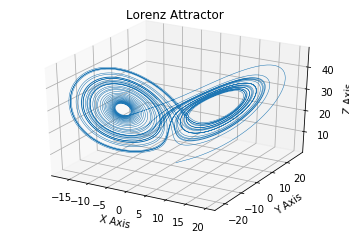

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y


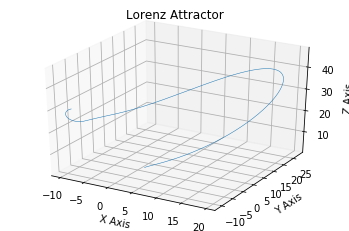

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -19.9625 1 + -1.7237 z + 0.6343 y^2
para t = 
1


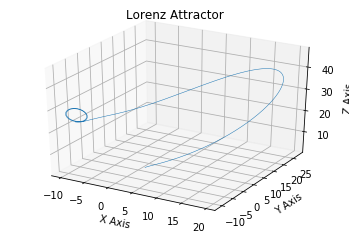

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -51.3970 1 + 0.6151 y^2
para t = 
2


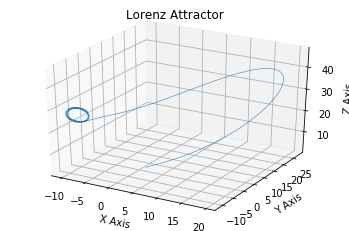

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -12.9859 1 + -1.3914 z + 0.6128 y^2
para t = 
3


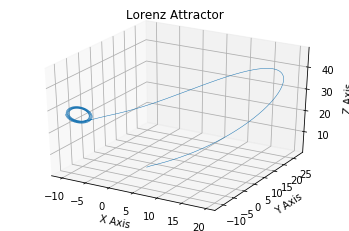

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -13.1608 1 + -1.3459 z + 0.6143 y^2
para t = 
4


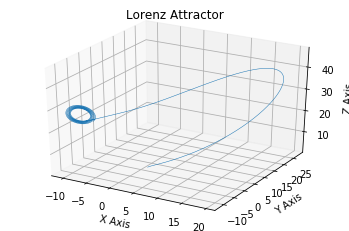

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -14.4752 1 + -1.2693 z + 0.6165 y^2
para t = 
5


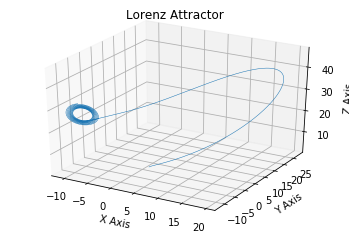

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -10.0972 1 + -9.3010 x + -2.5344 z + 0.2347 x z + 0.7202 y^2
para t = 
6


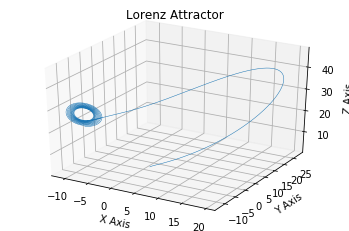

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
7


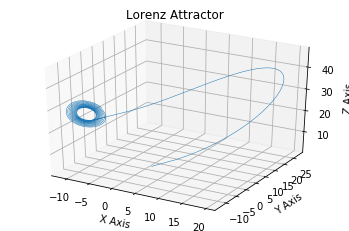

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
8


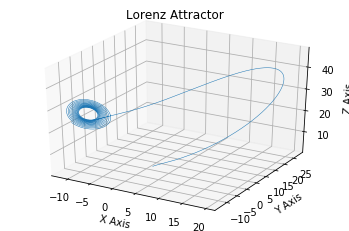

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
9


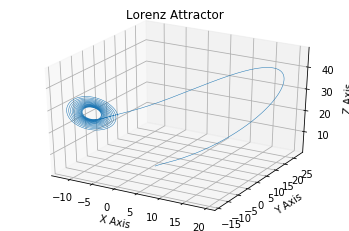

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
10


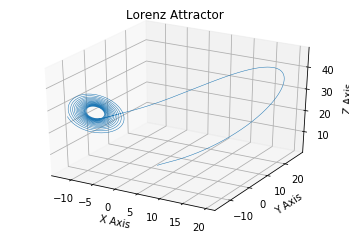

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
11


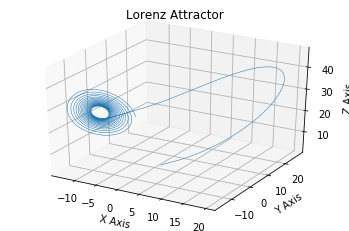

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
12


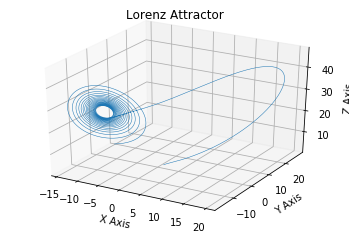

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
13


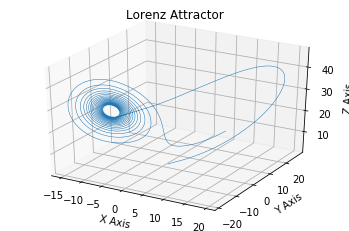

x' = -10.0000 x + 10.0000 y
y' = -1.3827 1 + 25.5172 x + -0.9524 x z
z' = -2.6667 z + 1.0000 x y
para t = 
14


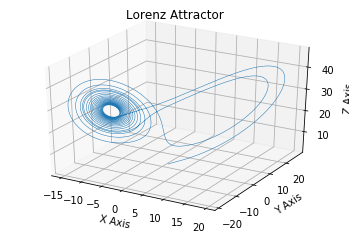

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
15


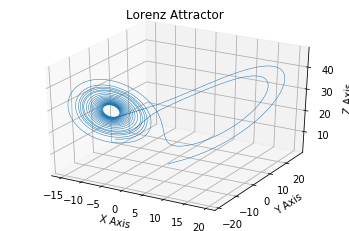

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
16


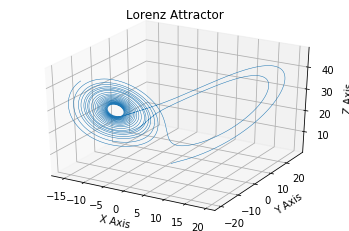

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
17


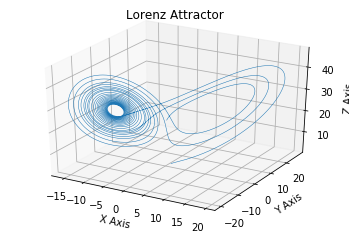

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
18


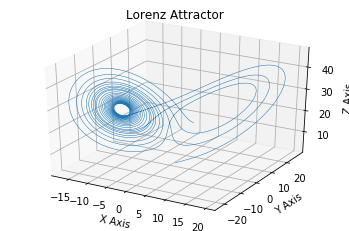

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
19


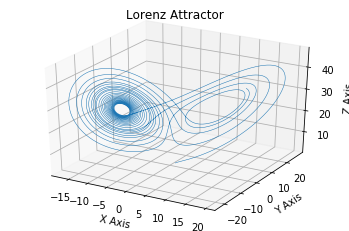

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
20


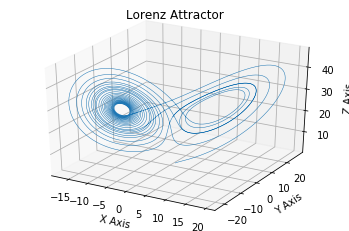

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
21


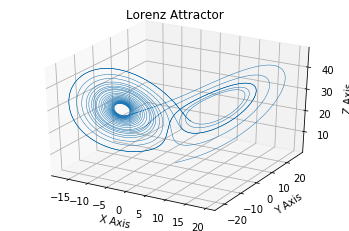

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
22


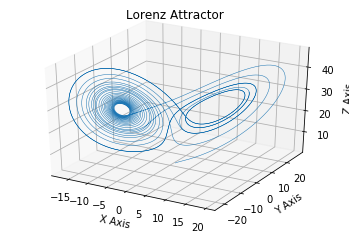

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
23


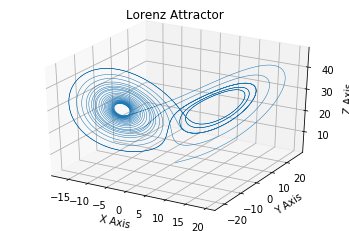

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
24


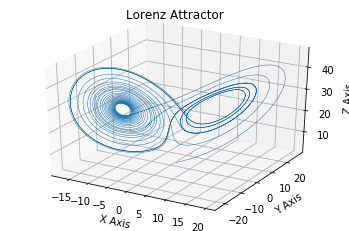

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
25


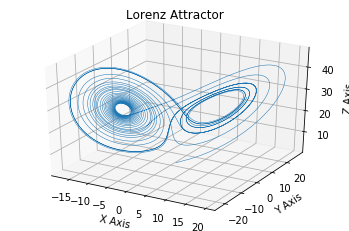

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
26


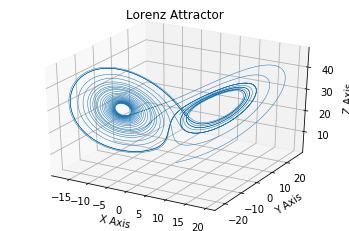

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
27


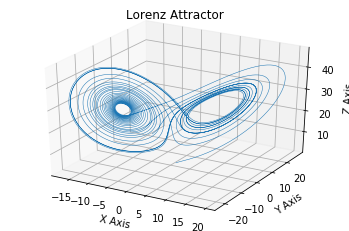

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
28


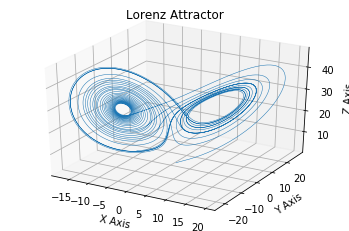

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
29


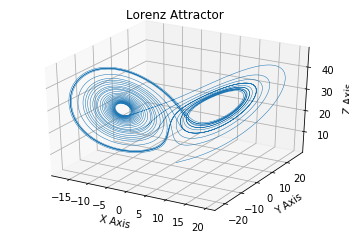

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
30


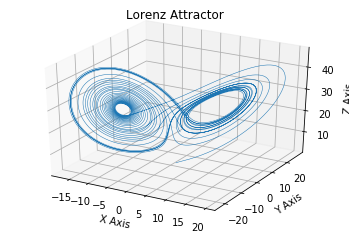

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
31


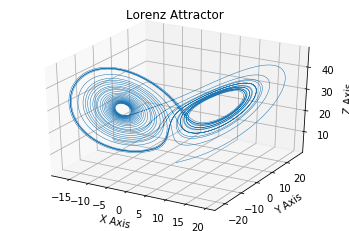

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
32


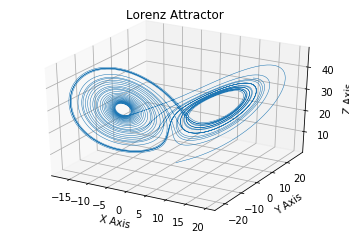

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
33


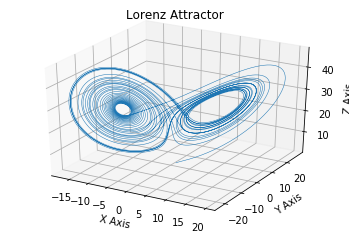

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
34


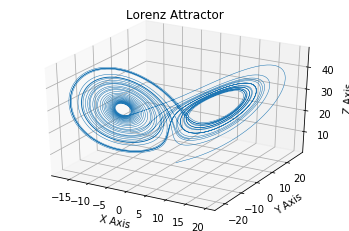

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
35


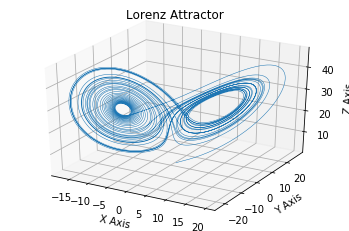

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
36


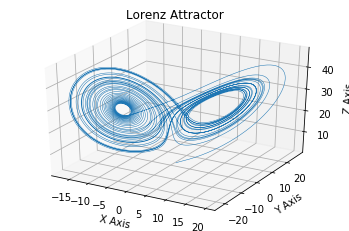

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
37


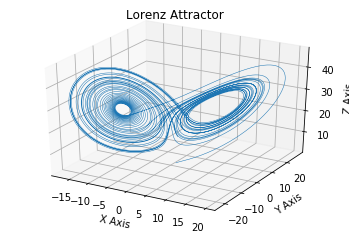

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
38


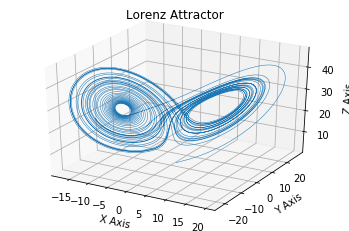

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
39


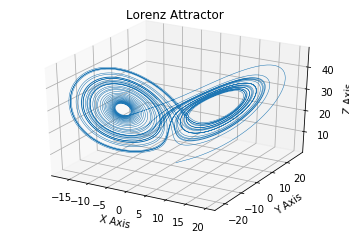

x' = -10.0000 x + 10.0000 y
y' = 28.0000 x + -1.0000 y + -1.0000 x z
z' = -2.6667 z + 1.0000 x y
para t = 
40


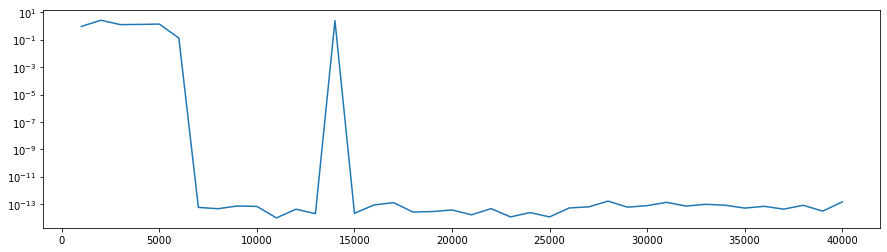

In [8]:
x_train, x_dot_train = calculate_data()
model = sindy_model(x_train, x_dot_train)
#model.print()
#print(model.coefficients())

result = [] #empiezo con la lista vacía
num_puntos = []
a=10.0
b=28.0
c=8.0/3.0
for i in range(1, 41):
    x_train, x_dot_train = calculate_data(t_max=i)
    model = sindy_model(x_train, x_dot_train)
    a_est = model.coefficients()[0][2]
    b_est = model.coefficients()[1][1]
    c_est = model.coefficients()[2][3] * -1
    result.append(abs(a-a_est)+abs(b-b_est)+abs(c-c_est))
    num_puntos.append(i/paso_tiempo)
    print("para t = ")
    print(i)
    
fig = plt.figure(figsize=(15, 4))
plt.semilogy(num_puntos, result)

#a partir de t=12, es decir, 12/0.01=1200 muestras ya tenemos buenos resultados. Entre 20 y 30 por alguna razón
#hay un gran pico en el error, ver array de resultados
#poner un attractor pequeñito en la grafica

Ahora alimento el modelo con otro punto inicial pero mismo vector de tiempos, [5, 6, 27]

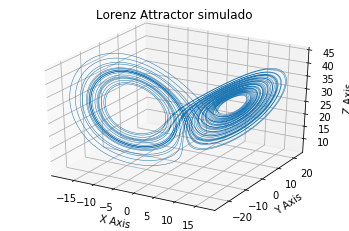

array([[ 5.        ,  6.        , 27.        ],
       [ 5.00994556,  5.99911044, 26.9580835 ],
       [ 5.01978444,  5.99844155, 26.91633399],
       ...,
       [ 3.39856372,  6.11343503, 11.02860147],
       [ 3.42583483,  6.16521972, 11.02015169],
       [ 3.45335206,  6.21744587, 11.012071  ]])

In [9]:
#simulacion:
x0_sim = [5.0, 6.0, 27.0]
t_sim = np.arange(0.0, 40.0, paso_tiempo)

x_sim = model.simulate(x0_sim, t_sim)
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_sim[:, 0] , x_sim[:, 1], x_sim[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor simulado")

plt.show()
x_sim

Comparativa entre datos reales y simulados:

error medio cuadratico:
53.7778486507002
71.19411483450988
52.707504035903675


Text(0.5, 1.0, 'Comparativa para eje z')

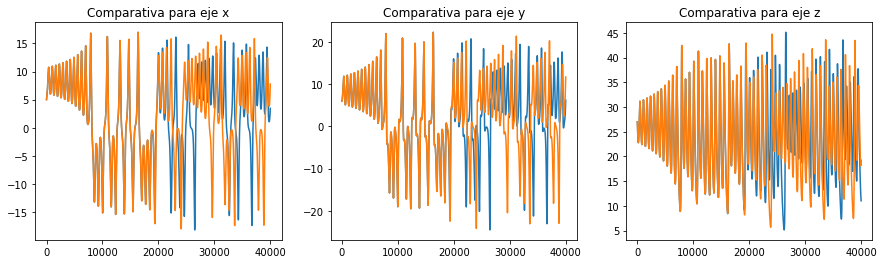

In [10]:
x_real = odeint(lorenz2, x0_sim, t_sim)
#calculo el error:
error = np.mean((x_real - x_sim) ** 2, axis=0)


print('error medio cuadratico:')
print(error[0])
print(error[1])
print(error[2])
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131)
ax.plot(x_sim[:, 0] )
ax.plot(x_real[:, 0])
ax.set_title("Comparativa para eje x")

ax = fig.add_subplot(132)
ax.plot(x_sim[:, 1] )
ax.plot(x_real[:, 1])
ax.set_title("Comparativa para eje y")

ax = fig.add_subplot(133)
ax.plot(x_sim[:, 2] )
ax.plot(x_real[:, 2])
ax.set_title("Comparativa para eje z")



Representación del atractor real:

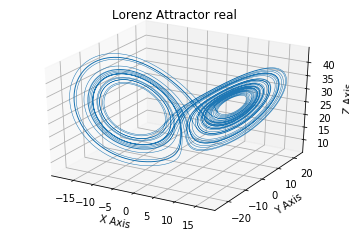

In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_real[:, 0] , x_real[:, 1], x_real[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor real")

plt.show()

No se mejoran los resultados a pesar de incrementar el número de decimales, la razón es que el sistema es caótico para unos tiempos superiores al de liaponov

### Prueba con distintos valores de a,b, c

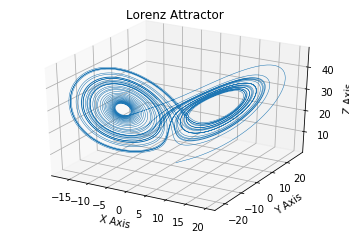

x' = -5.0000 x + 5.0000 y
y' = 99.9600 x + -1.0000 y + -1.0000 x z
z' = -15.0000 z + 1.0000 x y
x' = -4.9999999999999928945726423989981412887573242187500000 x + 4.9999999999999955591079014993738383054733276367187500 y
y' = 99.9600000000000790123522165231406688690185546875000000 x + -1.0000000000000399680288865056354552507400512695312500 y + -1.0000000000000013322676295501878485083580017089843750 x z
z' = -15.0000000000000035527136788005009293556213378906250000 z + 1.0000000000000013322676295501878485083580017089843750 x y


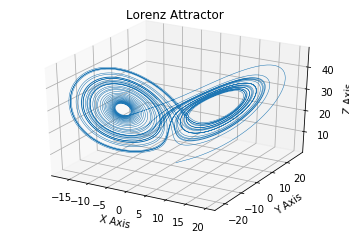

x' = -1.0000 x + 1.0000 y
y' = 50.0000 x + -1.0000 y + -1.0000 x z
z' = -8.0000 z + 1.0000 x y
x' = -0.9999999999999993338661852249060757458209991455078125 x + 0.9999999999999997779553950749686919152736663818359375 y
y' = 50.0000000000001634248292248230427503585815429687500000 x + -1.0000000000000546229728115577017888426780700683593750 y + -1.0000000000000017763568394002504646778106689453125000 x z
z' = -7.9999999999999946709294817992486059665679931640625000 z + 1.0000000000000006661338147750939242541790008544921875 x y


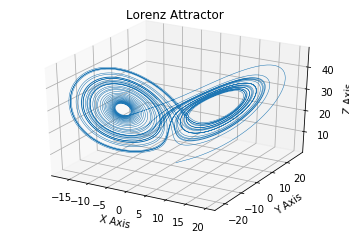

x' = -0.5000 x + 0.5000 y
y' = 30.0000 x + -1.0000 y + -1.0000 x z
z' = -2.0000 z + 1.0000 x y
x' = -0.4999999999999996669330926124530378729104995727539062 x + 0.4999999999999998889776975374843459576368331909179688 y
y' = 30.0000000000001207922650792170315980911254882812500000 x + -1.0000000000000532907051820075139403343200683593750000 y + -1.0000000000000015543122344752191565930843353271484375 x z
z' = -2.0000000000000013322676295501878485083580017089843750 z + 1.0000000000000002220446049250313080847263336181640625 x y


In [12]:
#según wikipedia para valores de b=99.96 se comporta como un nudo tórico (que es eso?)
x_train, x_dot_train = calculate_data(a = 5.0, b = 99.96,c = 15.0)
model = sindy_model(x_train, x_dot_train)
model.print(precision=52)


x_train, x_dot_train = calculate_data(a = 1.0, b = 50.0,c = 8.0)
model = sindy_model(x_train, x_dot_train)
model.print(precision=52)

x_train, x_dot_train = calculate_data(a = 0.5, b = 30.0,c = 2.0)
model = sindy_model(x_train, x_dot_train)
model.print(precision=52)

#nada mal los resultados, salvo igual por el b=50, el 47 se va un poco

## Solver de Pablo

4001


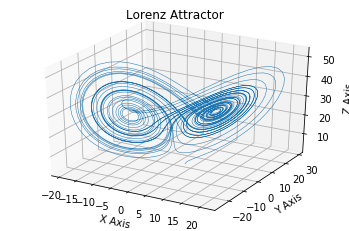

In [13]:
# Set initial values
x0 = [3., 1., 1.]
xs, ys, zs = solverLorenz(x0, num_steps=4000)

x_train = np.ones((xs.size, 3))
x_train[:, 0] = xs 
x_train[:, 1] = ys 
x_train[:, 2] = zs 
print(x_train.shape[0])
x_dot_train_measured = np.ones((x_train.shape[0], 3))


for i in range(x_train.shape[0]):
    x_dot_train_measured[i] = lorenz(x_train[i])


# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

Creo el modelo de sindy para el solver de Pablo

In [14]:
# Fit the model, me creo el modelo dinámico 

poly_order = 4 #orden 3 y 4 es el que mejor lo hace
threshold = 0.2

#pysindy calcula las ecs que gobierna el movimiento
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, normalize=True),
    feature_library=ps.PolynomialLibrary(degree=poly_order),#ps.FourierLibrary(n_frequencies=2),#
    feature_names=['x', 'y', 'z'],
    
    #fit_intercept=True,
)

#la doc dice que en t hay que poner el time step
model.fit(x_train, t=paso_tiempo, quiet=True, x_dot=x_dot_train_measured)

model.equations(precision=52)
model.print(precision=5)

x' = -10.00000 x + 10.00000 y
y' = 28.00000 x + -1.00000 y + -1.00000 x z
z' = -2.66667 z + 1.00000 x y


Simulo para el solver de Pablo con otro punto

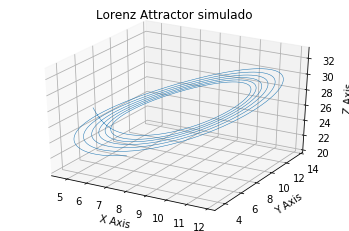

In [15]:
#simulacion:
x0_sim = [5.0, 6.0, 27.0]
t_sim = np.arange(0.0, 4.0, paso_tiempo)
x_sim = model.simulate(x0_sim, t_sim)
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_sim[:, 0] , x_sim[:, 1], x_sim[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor simulado")

plt.show()



Calculo el error para este solver:

error medio cuadratico:
119.98473556512519
141.2563212199388
73.20942127262511


Text(0.5, 1.0, 'Comparativa para eje z')

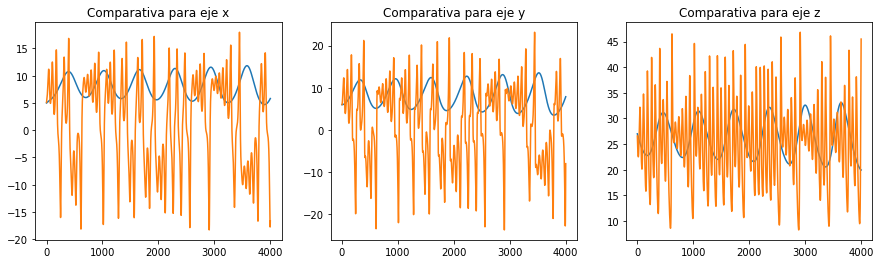

In [16]:
x_r, y_r, z_r = solverLorenz([5, 6, 27], num_steps=int(4.0/paso_tiempo))
x_real = np.ones((x_r.size-1, 3))

x_real[:, 0] = x_r[1:] 
x_real[:, 1] = y_r[1:] 
x_real[:, 2] = z_r[1:] 

#calculo el error
error = np.mean((x_real - x_sim) ** 2, axis=0)


print('error medio cuadratico:')
print(error[0])
print(error[1])
print(error[2])

fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131)
ax.plot(x_sim[:, 0] )
ax.plot(x_real[:, 0])
ax.set_title("Comparativa para eje x")

ax = fig.add_subplot(132)
ax.plot(x_sim[:, 1] )
ax.plot(x_real[:, 1])
ax.set_title("Comparativa para eje y")

ax = fig.add_subplot(133)
ax.plot(x_sim[:, 2] )
ax.plot(x_real[:, 2])
ax.set_title("Comparativa para eje z")



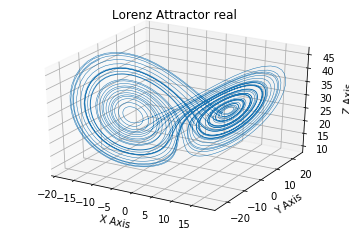

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_real[:, 0] , x_real[:, 1], x_real[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor real")

plt.show()

# Añadir términos a las ecuaciones de Lorenz

### Lorenz-Pablo (sin(xyz) y atan)

In [18]:
def lorenz_Pablo(state, t):
    x, y, z = state  # saco las coordenadas del vector que me pasan
    b = 28.0
    a = 10.0
    c = 8.0/3.0
    #print(math.sin(x*y*z))
    #print(math.atan(x))
    # estan son las derivadas de cada coordenada
    return a * (y - x)+ math.sin(y*x)*6, x * (b - z) - y + math.sin(y*z)*6, math.sin(x*z)#+ math.atan(x) 

/home/meri/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


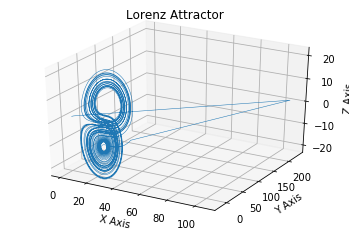

In [19]:
np.float128
dt = 0.01
t_train = np.arange(0.0, 40.0, paso_tiempo)
x0_train = [1.0, 1.0, 1.0]           
#odeint resuelve edos dado en el primer argumento la funcion que devuelve las ecuaciones dx/dt = ...
x_train = odeint(lorenz_Pablo, x0_train, t_train)

x_dot_train_measured = np.ones((t_train.size, 3))

for i in range(t_train.size):
    x_dot_train_measured[i] = lorenz_Pablo(x_train[i], t_train)


#ploteo los datos de entrenamiento:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show() 


In [20]:
# Fit the model, me creo el modelo dinámico 

poly_order = 6
threshold = 0.2

#pysindy calcula las ecs que gobierna el movimiento
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, normalize=True),
    feature_library=ps.FourierLibrary(n_frequencies=1),#ps.PolynomialLibrary(degree=poly_order),
    feature_names=['x', 'y', 'z'],
    
    #fit_intercept=True,
)

#la doc dice que en t hay que poner el time step
model.fit(x_train, t=dt, x_dot=x_dot_train_measured, quiet=True)

model.equations(precision=7)
model.print(precision=7)
#model.coefficients()

x' = 33.3877642 sin(1 x) + -2.9869530 cos(1 x) + 17.4620856 sin(1 y) + 16.6500558 cos(1 y) + -8.1207154 sin(1 z) + -3.0443006 cos(1 z)
y' = -95.3226610 sin(1 x) + 8.6334441 cos(1 x) + -52.8501963 sin(1 y) + -49.6616318 cos(1 y) + 48.4463345 sin(1 z) + 18.3458984 cos(1 z)
z' = 0.0000000


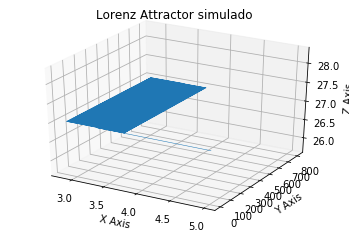

array([[  5.        ,   6.        ,  27.        ],
       [  4.9723299 ,   6.09899128,  27.        ],
       [  4.9464525 ,   6.19254082,  27.        ],
       ...,
       [  3.36912083, 804.19806579,  27.        ],
       [  3.37337918, 804.2051593 ,  27.        ],
       [  3.37762533, 804.21226583,  27.        ]])

In [21]:
#simulacion:
x0_sim = [5.0, 6.0, 27.0]
t_sim = np.arange(0.0, 40.0, paso_tiempo)
x_sim = model.simulate(x0_sim, t_sim)
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_sim[:, 0] , x_sim[:, 1], x_sim[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor simulado")

plt.show()
x_sim

# Atractor de Rössler

In [22]:
#primero definir la ec para que me devuelva los valores de las derivadas:
def rossler(state, t, a=0.2, b=0.2, c=5.7):
    x,y,z = state
    return -y-z, x+a*y, b + z*(x - c)
    

In [23]:
def calculate_data_rossler(t_max=40.0, dt=paso_tiempo, x0_train=[1.0, 1.0, 1.0], a=0.2, b=0.2, c=5.7):
    
    
    t_train = np.arange(0.0, t_max, dt)
          
    #odeint resuelve edos dado en el primer argumento la funcion que devuelve las ecuaciones dx/dt = ...
    x_train = odeint(rossler, x0_train, t_train)

    x_dot_train_measured = np.ones((t_train.size, 3))
    for i in range(t_train.size):
        x_dot_train_measured[i] = rossler(x_train[i], t_train, a,b,c)


    #x_dot_train_measured = np.array(
    #    [lorenz2(x_train[i]) for i in range(t_train.size)]
    #)

    #ploteo los datos de entrenamiento:
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Rossler Attractor")

    plt.show()
    
    return x_train, x_dot_train_measured

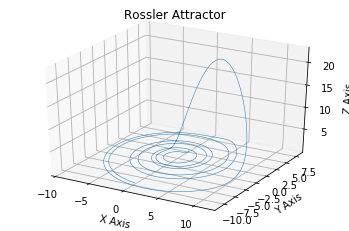

x' = -1.0000 y + -1.0000 z
y' = 0.9876 x
z' = -13.9889 z + 0.9995 x z


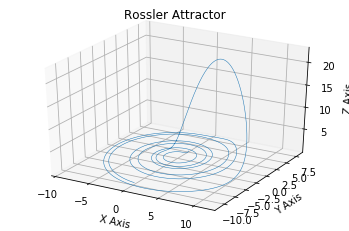

x' = -1.0000 y + -1.0000 z + -0.0411
y' = 1.0000 x + 0.2000 y + -0.0634
z' = -5.7000 z + 1.0000 x z + -0.2442


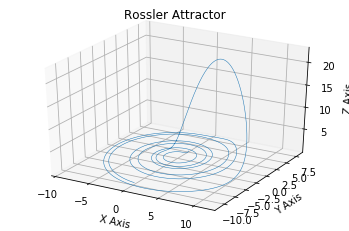

x' = -1.0000 y + -1.0000 z
y' = 1.0000 x + 2.0000 y
z' = 5.0000 1 + -5.7000 z + 1.0000 x z


In [24]:
x_train, x_dot_train = calculate_data_rossler(a=0.1, b=0.1, c=14)
model = sindy_model(x_train, x_dot_train)

x_train, x_dot_train = calculate_data_rossler(dt=0.01)
model = sindy_model(x_train, x_dot_train, terminos_ctes=True, dt=0.01)

x_train, x_dot_train = calculate_data_rossler(a=2, b=5, c=5.7, dt=0.01)
model = sindy_model(x_train, x_dot_train, terminos_ctes=False, dt=0.01)



Con valores pequeños de los coef, como a o b, no calcula bien el termino que los acompaña

Ahora dibujo el atractor real con el predicho por sindy con el flag de fit_intercept a true

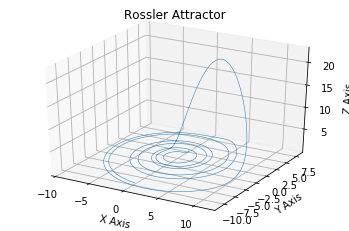

x' = -1.0000 y + -1.0000 z + -0.0409
y' = 1.0000 x + 0.2000 y + -0.0634
z' = -5.7000 z + 1.0000 x z + -0.2435


In [25]:
#datos reales
x_train, x_dot_train = calculate_data_rossler()
#calculo el modelo
model = sindy_model(x_train, x_dot_train, terminos_ctes=True)



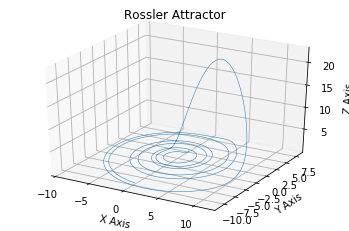

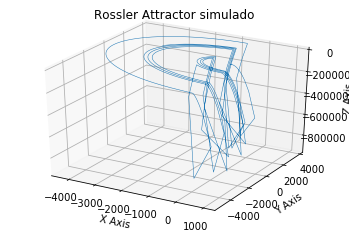

In [26]:
#datos reales
x_train, x_dot_train = calculate_data_rossler()

x0_sim = [1.0, 1.0, 1.0]
t_sim = np.arange(0.0, 40.0, paso_tiempo)
x_sim = model.simulate(x0_sim, t_sim)

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_sim[:, 0] , x_sim[:, 1], x_sim[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Rossler Attractor simulado")

plt.show()
#es horrible el resultado

# Atractor de Thomas

Combinaré la librería polinómica y la de Fourier:

In [27]:
#primero definir la ec para que me devuelva los valores de las derivadas:
def thomas(state, t, b=0.208186):
    x,y,z = state
    return math.sin(y)-b*x, math.sin(z)-b*y, math.sin(x)-b*z

In [28]:
def calculate_data_thomas(t_max=40.0, dt=paso_tiempo, x0_train=[1.0, 20.0, -5.0], b=0.208186):
    
    t_train = np.arange(0.0, t_max, dt)
          
    #odeint resuelve edos dado en el primer argumento la funcion que devuelve las ecuaciones dx/dt = ...
    x_train = odeint(thomas, x0_train, t_train)

    x_dot_train_measured = np.ones((t_train.size, 3))
    for i in range(t_train.size):
        x_dot_train_measured[i] = thomas(x_train[i], t_train, b)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Thomas Attractor")

    plt.show()
    
    return x_train, x_dot_train_measured

In [29]:
 #funion que alimenta sindy con la combinacipn de polinomica+fourier
def sindy_model_PF(x_train, x_dot_train, threshold = 0.2, terminos_ctes=False, dt=paso_tiempo):
    combined_library = ps.PolynomialLibrary() + ps.FourierLibrary()
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold, normalize=True, fit_intercept=terminos_ctes),
        feature_library=combined_library,
        feature_names=['x', 'y', 'z'],
    )

    #la doc dice que en t hay que poner el time step
    model.fit(x_train, t=dt,  quiet=True)

    #print(model.equations(precision=52))
    model.print(precision=4)
    #print(model.coefficients())
    return model

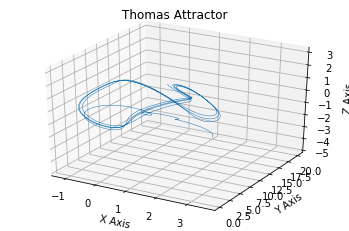

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)


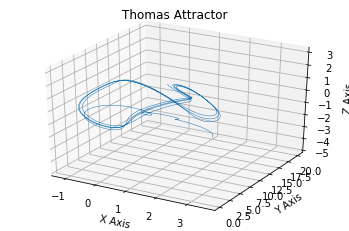

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)


In [30]:
x_train, x_dot_train = calculate_data_thomas(t_max=100)
model = sindy_model_PF(x_train, x_dot_train)

x_train, x_dot_train = calculate_data_thomas(t_max=100, b=5.0)
model = sindy_model_PF(x_train, x_dot_train)

Es importante pasarle un punto inicial que no tenga el mismo valor para las 3 coordenadas, sino, saca una linea recta. Calcula bien el modelo incluso aunque no se le pase la derivada

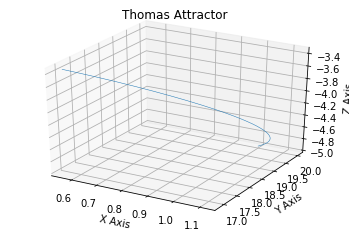

x' = 1.0632 sin(1 y)
y' = 0.0000
z' = 0.0000
para t = 
1


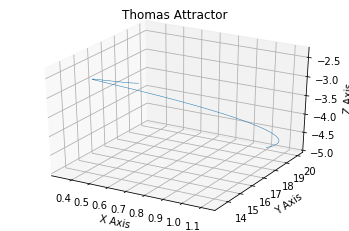

x' = 0.9948 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = 0.0000
para t = 
2


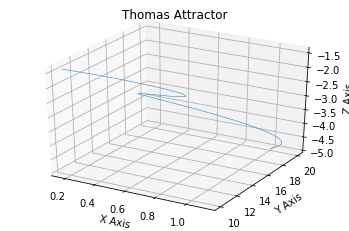

x' = 1.0217 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = 0.0000
para t = 
3


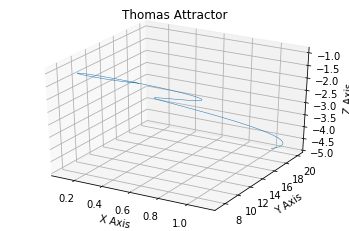

x' = 0.9949 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = 0.3266 x + 1.5768 sin(1 x)
para t = 
4


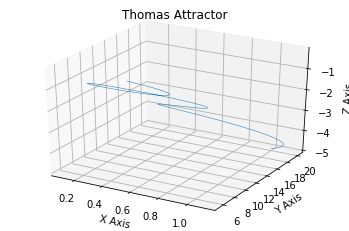

x' = 0.9895 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = 1.5525 x
para t = 
5


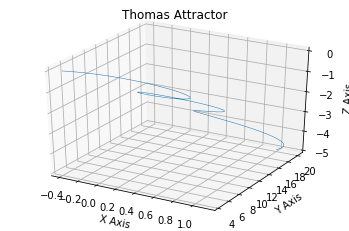

x' = 0.9967 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = 1.9456 x + -0.4651 sin(1 x)
para t = 
6


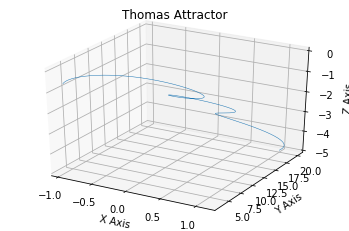

x' = 0.9690 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = 1.5515 sin(1 x)
para t = 
7


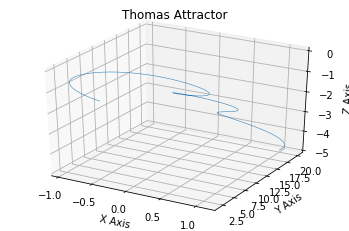

x' = 0.9829 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = 1.4064 sin(1 x)
para t = 
8


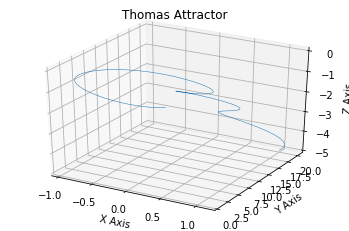

x' = 0.9841 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = 1.3985 sin(1 x)
para t = 
9


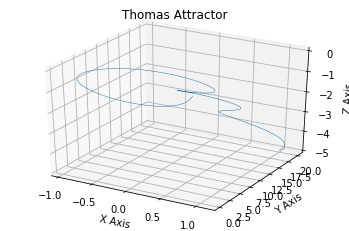

x' = 0.9703 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
10


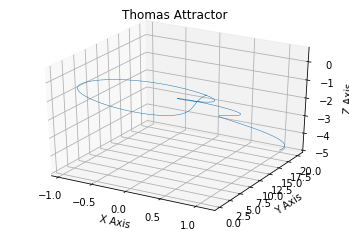

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
11


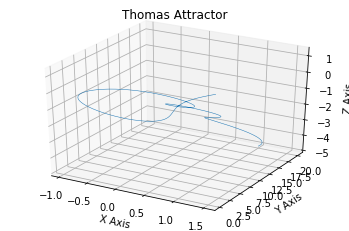

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
12


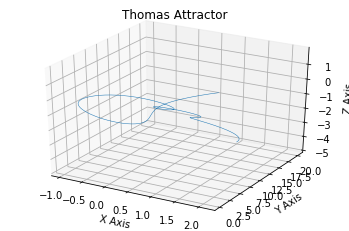

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
13


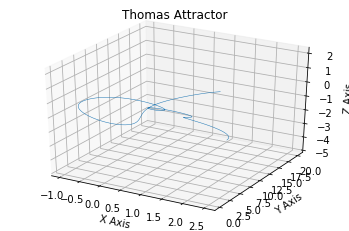

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
14


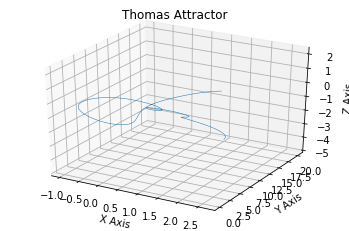

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
15


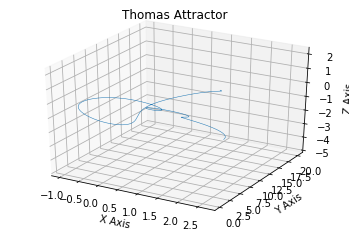

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
16


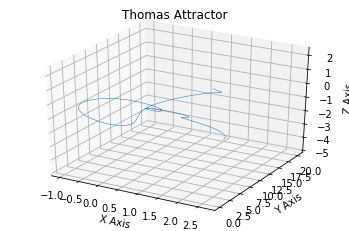

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
17


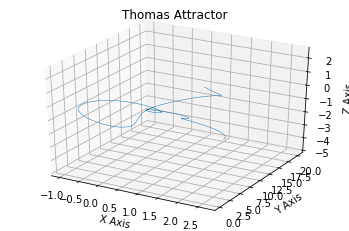

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
18


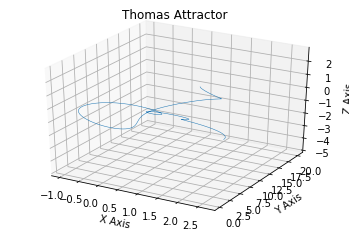

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
19


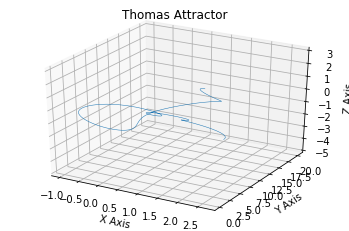

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
20


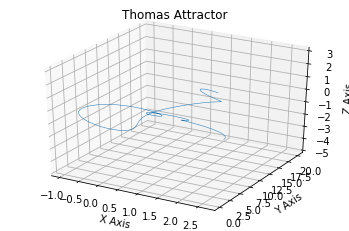

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
21


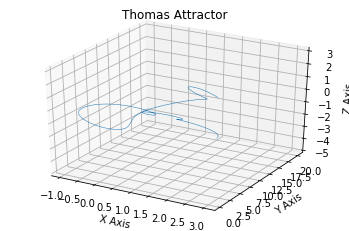

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
22


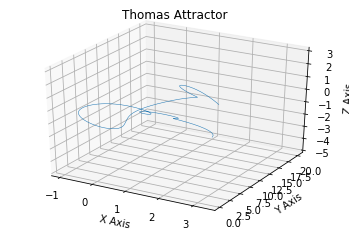

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
23


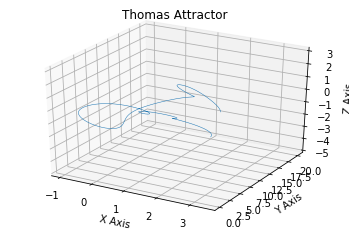

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
24


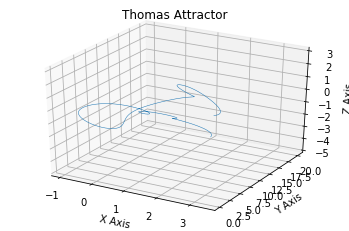

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
25


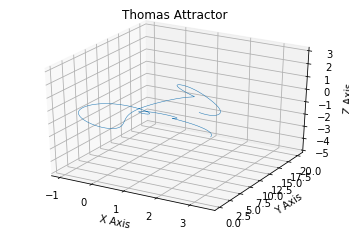

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
26


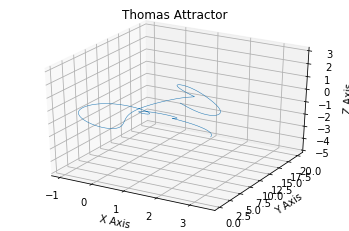

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
27


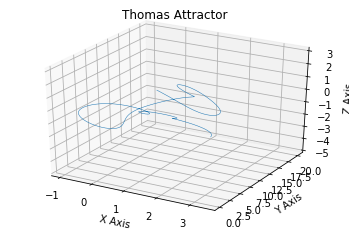

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
28


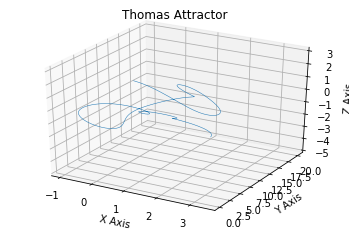

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
29


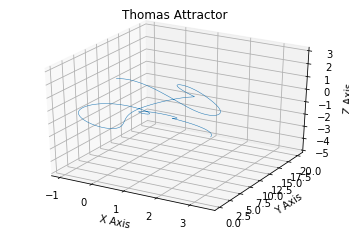

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
30


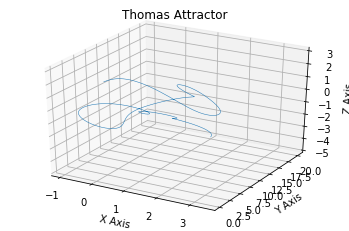

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
31


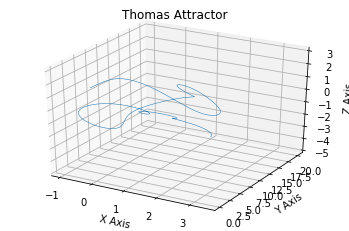

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
32


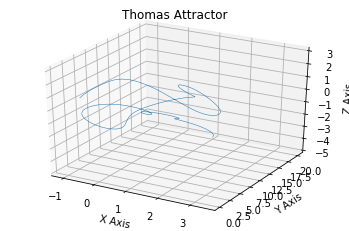

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
33


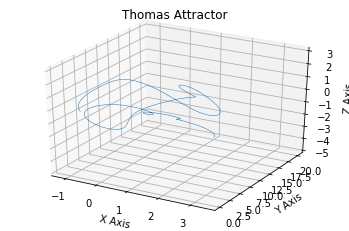

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
34


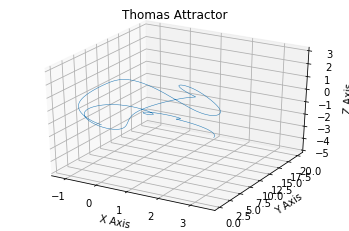

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
35


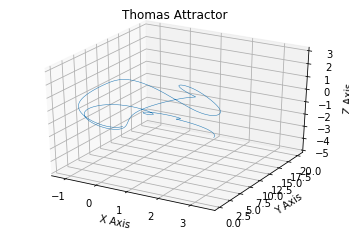

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
36


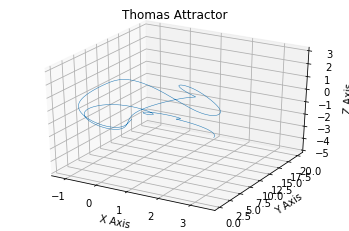

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
37


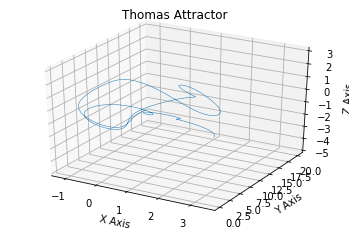

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
38


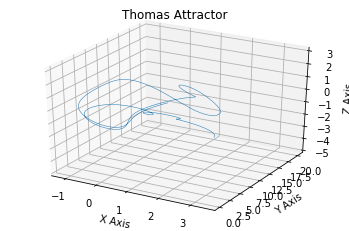

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
39


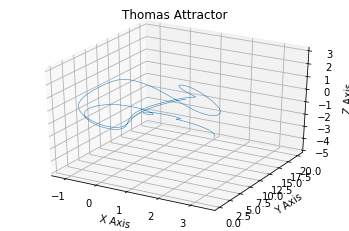

x' = -0.2082 x + 1.0000 sin(1 y)
y' = -0.2082 y + 1.0000 sin(1 z)
z' = -0.2082 z + 1.0000 sin(1 x)
para t = 
40


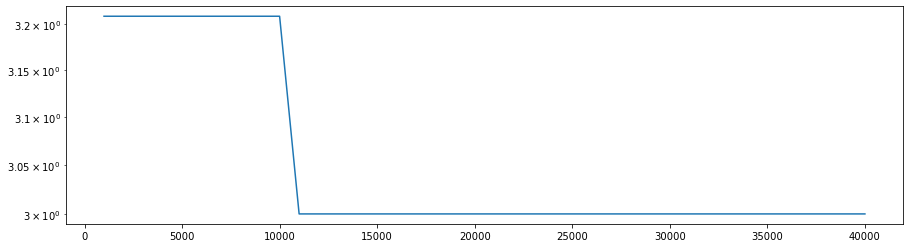

In [31]:
#calculo el error:

#model.print()
#print(model.coefficients())

result = [] #empiezo con la lista vacía
num_puntos = []
b=0.208186
for i in range(1, 41):
    x_train, x_dot_train = calculate_data_thomas(t_max=i)
    model = sindy_model_PF(x_train, x_dot_train)
    b_est = model.coefficients()[0][1] * -1
    result.append(abs(1-model.coefficients()[0][9])+abs(b-b_est)+abs(1-model.coefficients()[1][11])
                    +abs(1-model.coefficients()[2][7]))
    num_puntos.append(i/paso_tiempo)
    print("para t = ")
    print(i)
    
fig = plt.figure(figsize=(15, 4))
plt.semilogy(num_puntos, result)

# Atractor de Three-Scroll

In [32]:
#primero definir la ec para que me devuelva los valores de las derivadas:
def three_scroll(state, t, a=32.48, b=45.84, c=1.18, d=0.13, e=0.57, f=14.7):
    x,y,z = state
    return a*(y-x) + d*x*y, b*x - x*z + f*y, c*z + x*y - e*(x**2)

In [33]:
def calculate_data_three(t_max=40.0, dt=paso_tiempo, x0_train=[1.0, 8.0, -5.0], 
                             a=32.48, b=45.84, c=1.18, d=0.13, e=0.57, f=14.7):
    
    t_train = np.arange(0.0, t_max, dt)
          
    #odeint resuelve edos dado en el primer argumento la funcion que devuelve las ecuaciones dx/dt = ...
    x_train = odeint(three_scroll, x0_train, t_train)

    x_dot_train_measured = np.ones((t_train.size, 3))
    for i in range(t_train.size):
        x_dot_train_measured[i] = three_scroll(x_train[i], t_train, a, b, c, d, e, f)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Three Scroll Attractor")

    plt.show()
    
    return x_train, x_dot_train_measured

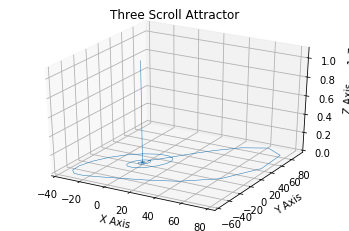

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y


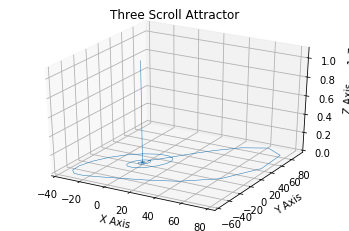

x' = -32.4800 x + 32.4800 y + 5.0000 x y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y


In [34]:
np.float128
x_train, x_dot_train = calculate_data_three(dt=0.01, t_max=10.0)
model = sindy_model(x_train, x_dot_train, dt=0.01)

x_train, x_dot_train = calculate_data_three(d=5.0, dt=0.01, t_max=10.0)
model = sindy_model(x_train, x_dot_train, dt=0.01)

Si ponemos un valor muy pequeño de d, por ejemplo el que tiene por defecto de 0.13, pysindy no lo saca al calcular el modelo. Al calcular el modelo con varias trayectorias ya es detectable

[[  0.   -32.48  32.48   0.     0.     5.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.  ]
 [  0.    45.84  14.7    0.     0.     0.    -1.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     1.18  -0.57   1.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.  ]]


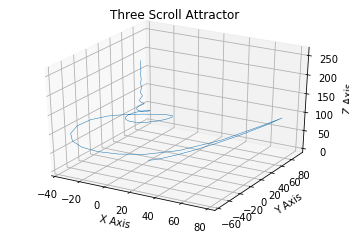

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
1


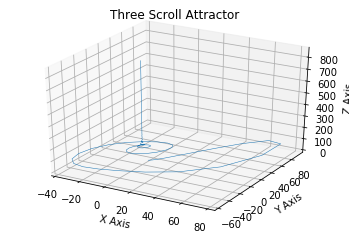

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
2


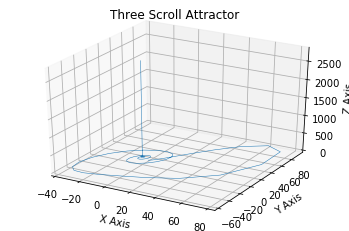

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
3


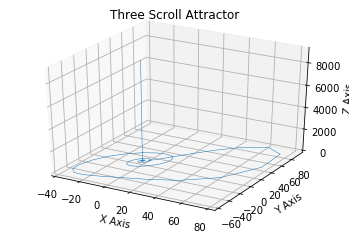

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
4


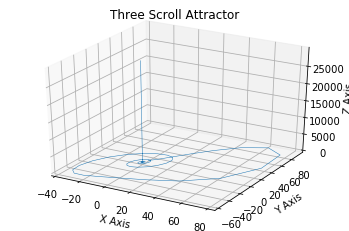

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
5


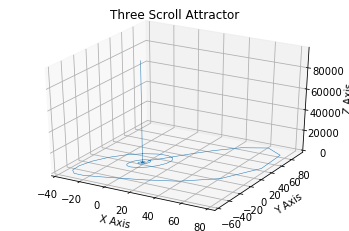

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
6


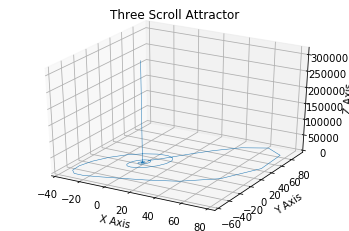

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
7


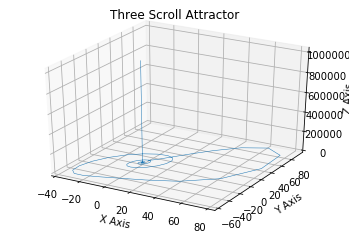

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
8


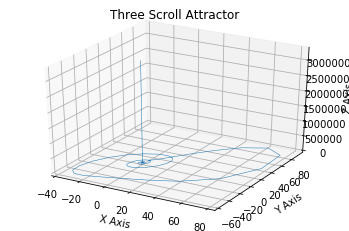

x' = -29.9708 x + 34.5442 y
y' = 45.8400 x + 14.7000 y + -1.0000 x z
z' = 1.1800 z + -0.5700 x^2 + 1.0000 x y
para t = 
9


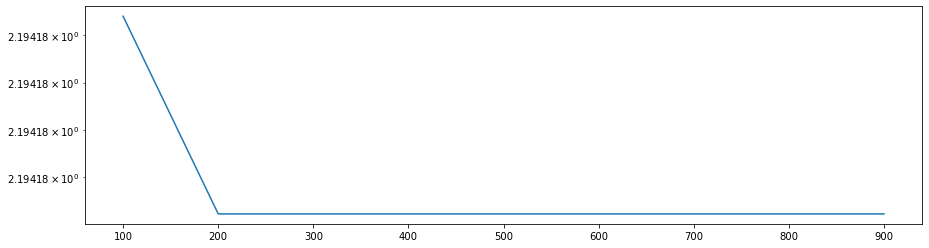

In [35]:
#calculo el error:
#print(x_train)
#model.print()
print(model.coefficients())

result = [] #empiezo con la lista vacía
num_puntos = []
a=32.48
b=45.84
c=1.18
d=0.13
e=0.57
f=14.7

for i in range(1, 10):
    x_train, x_dot_train = calculate_data_three(t_max=i, dt=0.01)
    model = sindy_model(x_train, x_dot_train, dt=0.01)
    a_est = model.coefficients()[0][2]
    b_est = model.coefficients()[1][1]
    c_est = model.coefficients()[2][3]
    d_est = model.coefficients()[0][5]
    e_est = model.coefficients()[2][4] * -1
    f_est = model.coefficients()[1][2]
    result.append(abs(a-a_est)+abs(b-b_est)+abs(c-c_est)+abs(d-d_est)+abs(e-e_est)+abs(f-f_est))
    num_puntos.append(i/0.01)
    print("para t = ")
    print(i)
    
fig = plt.figure(figsize=(15, 4))
plt.semilogy(num_puntos, result)


Por alguna razón no ejecuta bien para valores superiores de t=12, dice que odeint tiene mucha carga de trabajo

### Prueba con multiples trayectorias

In [42]:

#no poner demasiada resolución porque sino odeint falla
n_trajectories = 20
x0s = np.array([36, 48, 41]) * (
    np.random.rand(n_trajectories, 3) - 0.5
) + np.array([0, 0, 25])
x_train_multi = []
t_train_multi = []
for i in range(n_trajectories):
    n_samples = np.random.randint(500, 1000)
    t = np.arange(0, n_samples * 0.01, 0.01)
    x_train_multi.append(odeint(three_scroll, x0s[i], t))
    t_train_multi.append(t)

model = ps.SINDy(optimizer=ps.STLSQ(),
                feature_library=ps.PolynomialLibrary(), 
                 feature_names=['x', 'y', 'z'])
model.fit(x_train_multi, t=t_train_multi, multiple_trajectories=True)
model.print()



x' = -31.756 x + 31.756 y + 0.125 x y
y' = 42.316 x + 14.695 y + -0.950 x z
z' = 1.180 z + -0.522 x^2 + 0.942 x y


/home/meri/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.85177e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/meri/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.85177e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/meri/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.85177e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Predice mejor, pues llega a detectar los valores de los coeficientes muy pequeños. Antes la d no la detectaba bien por el valor tan pequeño que tenía, ahora si lo coge mejor